# Instacart Market Basket Analysis

Instacart is a online grocery delivery service, they pick up goods from shops like Walmart, Costco etc., and deliver to customers. They have processed over 3 million orders. Speciality being delivery time is less than 2 hours so ability to predict customers next order wouldld be of great importance.

In this project I would be trying to analyze which factors effect customers orders, and predict what orders would be reordered next.

## Index
1. Extract the data and fill the gaps
2. Understand the data
3. Preprocesssing stage
4. Training different models to set a Benchmark
5. Improvise the Model and Repeat
6. Predict on Test data.

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [6]:
import os
# List all the data we have.
print(os.listdir('data'))

['.DS_Store', 'aisles.csv', 'departments.csv', 'order_products__prior.csv', 'order_products__train.csv', 'orders.csv', 'products.csv', 'sample_submission.csv']


# 1. Extract the Data

In [7]:
aisles      = pd.read_csv('data/aisles.csv')
departments = pd.read_csv('data/departments.csv')
order_prior = pd.read_csv('data/order_products__prior.csv')
order_train = pd.read_csv('data/order_products__train.csv')
orders      = pd.read_csv('data/orders.csv')
products    = pd.read_csv('data/products.csv')

In [8]:
print(aisles.shape)
print(aisles.head())

(134, 2)
   aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


In [5]:
print(departments.shape)
print(departments.head())

(21, 2)
   department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol


In [6]:
print (order_prior.shape)
print(order_prior.sort_values('order_id').head(10))

(32434489, 4)
    order_id  product_id  add_to_cart_order  reordered
0          2       33120                  1          1
1          2       28985                  2          1
2          2        9327                  3          0
3          2       45918                  4          1
4          2       30035                  5          0
5          2       17794                  6          1
6          2       40141                  7          1
7          2        1819                  8          1
8          2       43668                  9          0
16         3       32665                  8          1


In [7]:
print(order_train.shape)
print(order_train[ order_train['order_id']==1] )

(1384617, 4)
   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1
5         1       13176                  6          0
6         1       47209                  7          0
7         1       22035                  8          1


In [8]:
print(orders.shape,'\n',orders.head())

(3421083, 7) 
    order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order
0   2539329        1    prior             1          2                  8                     NaN
1   2398795        1    prior             2          3                  7                    15.0
2    473747        1    prior             3          3                 12                    21.0
3   2254736        1    prior             4          4                  7                    29.0
4    431534        1    prior             5          4                 15                    28.0


In [9]:
print(products.shape)
print(products.head())

(49688, 4)
   product_id                                       product_name  aisle_id  department_id
0           1                         Chocolate Sandwich Cookies        61             19
1           2                                   All-Seasons Salt       104             13
2           3               Robust Golden Unsweetened Oolong Tea        94              7
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38              1
4           5                          Green Chile Anytime Sauce         5             13


## 2. Understanding Data

# 2.1 Chance of Items being ordered for first time
Percentage of old items in order vs new items in orders ~ 60%
So even though we predict all the items that will be reordered there is a 40% chance that a new item might be added by 
the user with the next order.

In [12]:
detailed_train_data = order_train
reordered = (detailed_train_data[detailed_train_data['reordered']==1].shape[0])
not_reordered = (detailed_train_data[detailed_train_data['reordered']==0].shape[0])
print( "percentage of reorders =", reordered*100 / (reordered+not_reordered))

percentage of reorders = 59.85944127509629


Lets see which group of items are popularly reordered in training set

In [13]:
# Joining orders , products and departments to give some meaningful names to each product

detailed_train_data = pd.merge(order_train,products,how='left', left_on=['product_id'], right_on = ['product_id'])
detailed_train_data = pd.merge(detailed_train_data,departments,how='left', left_on=['department_id'], right_on = ['department_id'])

In [14]:
# Extract only elements which have been ordered before
group = detailed_train_data[detailed_train_data['reordered']==1]

In [15]:
# Grouping according to individual department and getting how many orders have been placed categorically
group = group[['department','reordered','department_id']].groupby(['department','department_id']).sum()
group = group.reset_index()

# 2.2 Each department is different.

The pie chart below shows that the quantitiy of reordered items of produce are the most, followed by dairy eggs.

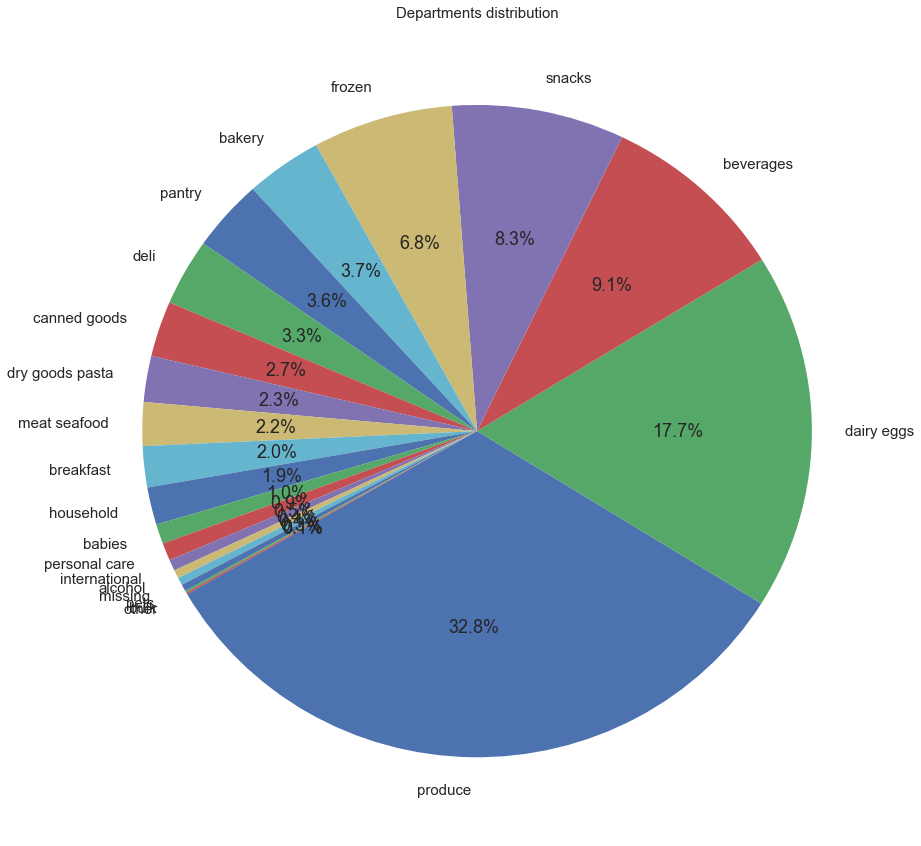

In [16]:
group = group.sort_values(by=['reordered'],ascending=[False])
temp = group.reordered
label = np.array(group.department)
values = np.array(100*temp/temp.sum())
sns.set(font_scale=1.5)
plt.figure(figsize=(15,15))
plt.pie(values, labels=label, autopct='%1.1f%%', startangle=210)
plt.title("Departments distribution", fontsize=15)
plt.show()

# 2.2.1 It's not always about the quantity    
Although produce has more number of reorders, we need to see how many of the total produce orders are actually reordered. This explanation says dairy eggs have higher rate of reorder. Say if there are 20 orders although 7 of the orders of produce are reordered and 3 orders of dairy are reordered, there might have been a total of 10 produce, but only 3 of dairy all of which are reordered. Thus predicting dairy eggs to be reordered more would give us better results.

This analysis based on the trainig data gives us an idea that few categories are reordered relatively very high compared to others but It's not a fair way to estimate which category is being reordered more, since say if all the orders in babies department have been re-ordered It's corresponding measure should be high. So we should consider    

                       (total reorders in a category) /(total orders in each category)
                       
As we can see below though number of reorders snacks being high compared to say, pets. Ratio doesn't indicate the same. This gives a more clear picture say even if number of orders of snacks were relatively high, they are not quite reordered in the same way as pet products were.

This could indicate how we always try to experiment with snacks and also not to exclude different flavors for each product we have which might cause this behaviour as well.

In [17]:
total_group = detailed_train_data.groupby(['department','department_id']).count().reset_index()

group = group[['department','reordered','department_id']].groupby(['department','department_id']).sum()
group = group.reset_index()

In [18]:
ratio = pd.DataFrame({'department':total_group.department,'ratio':group['reordered']/total_group.reordered}).sort_values('ratio',ascending=False)

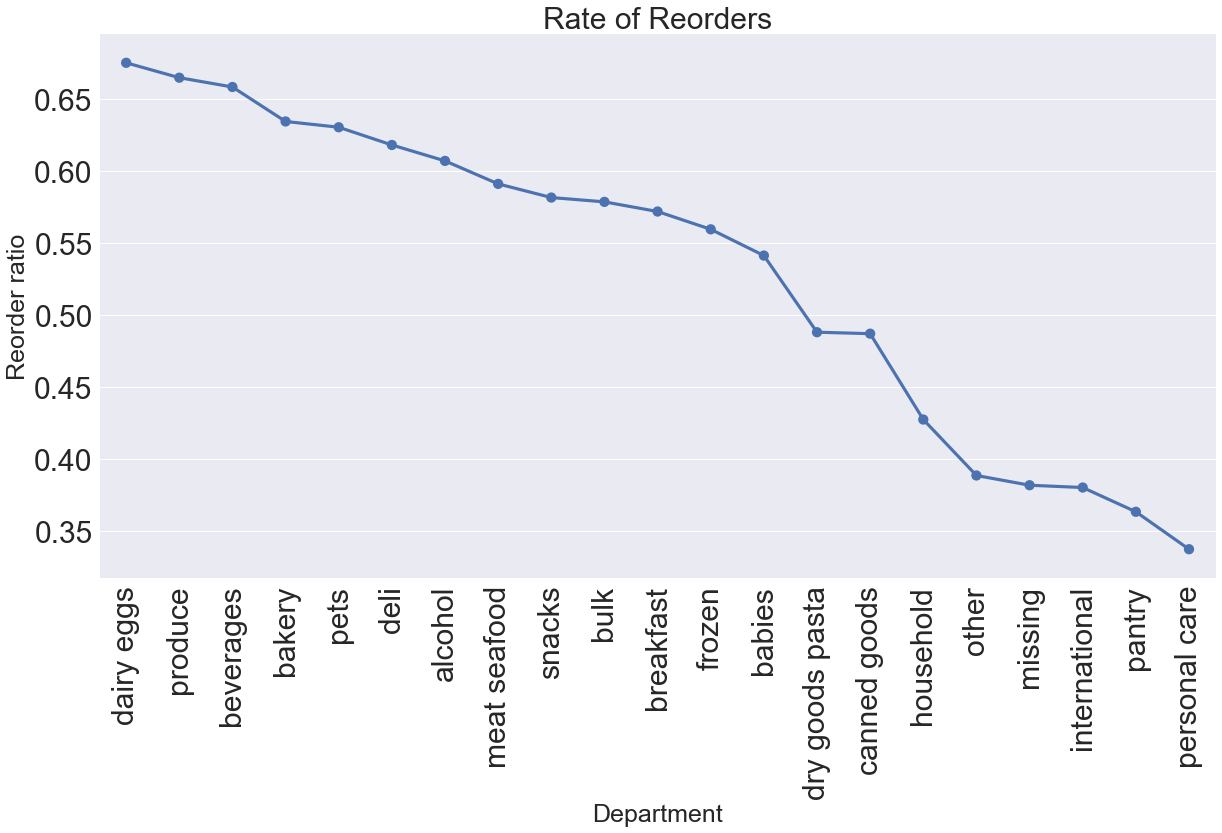

In [19]:
plt.figure(figsize=(20,10))
sns.set(font_scale=3) 
sns.pointplot(ratio.department,(ratio.ratio))
plt.xlabel('Department', fontsize=25)
plt.ylabel('Reorder ratio', fontsize=25)
plt.title("Rate of Reorders", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()

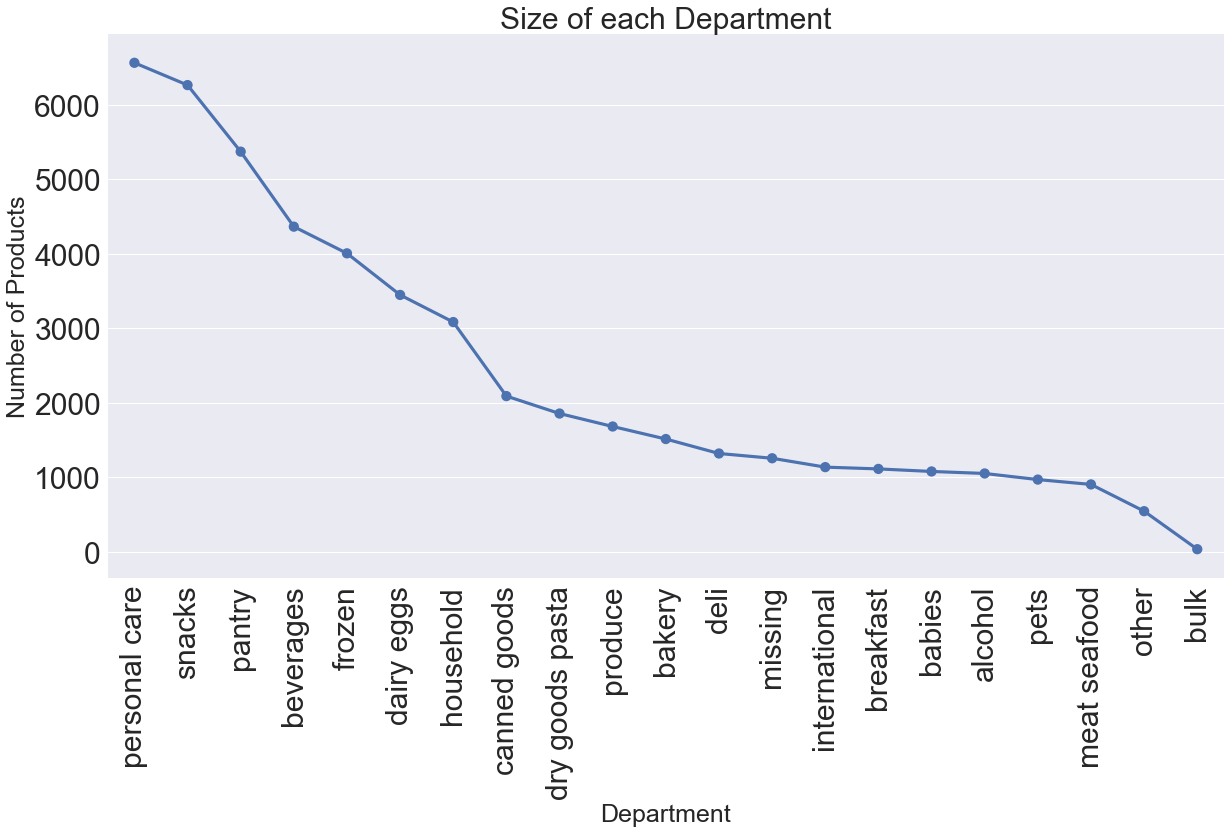

In [20]:
total_products = pd.merge(products,departments,how='left', left_on=['department_id'], right_on = ['department_id'])
total_products = total_products.groupby('department').agg('count').reset_index().sort_values('product_id',ascending=False)
total_products.product_id = total_products.product_id 
plt.figure(figsize=(20,10))
sns.set(font_scale=3) 
sns.pointplot(total_products.department,total_products.product_id)
plt.xlabel('Department', fontsize=25)
plt.ylabel('Number of Products', fontsize=25)
plt.title("Size of each Department", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()

In [21]:
joint = pd.merge(total_products[['department','product_id']],ratio,on='department').reset_index()
joint.columns=['i','department','product_count','reorder_ratio']
scaler = MinMaxScaler()
joint[['product_count','reorder_ratio']] = scaler.fit_transform(joint[['product_count','reorder_ratio']])

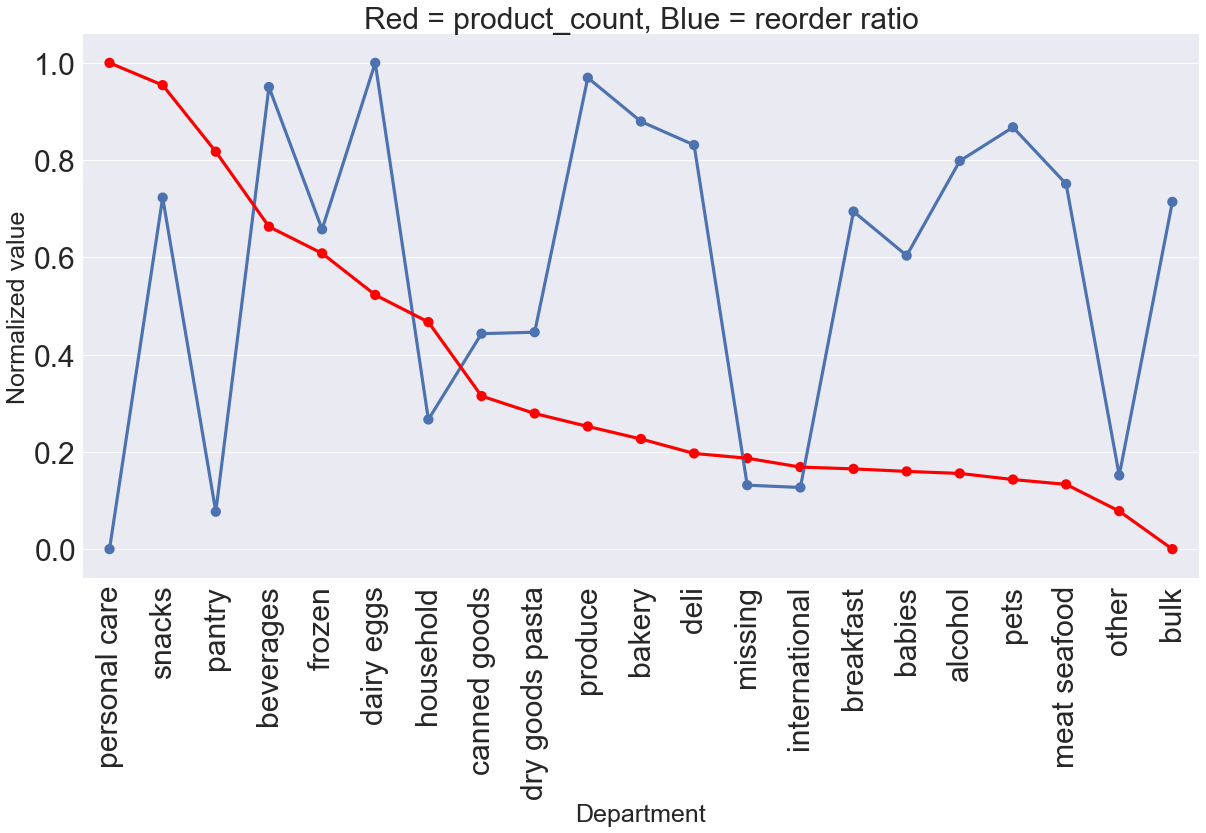

In [22]:
plt.figure(figsize=(20,10))
sns.set(font_scale=3) 
sns.pointplot(joint.department,joint.reorder_ratio)
sns.pointplot(joint.department,joint.product_count,color='red')
plt.xlabel('Department', fontsize=25)
plt.ylabel('Normalized value', fontsize=25)
plt.title("Red = product_count, Blue = reorder ratio", fontsize=30)
plt.xticks(rotation='vertical')
plt.show()

## Freedom of more
When users have more products say in case of first 3 departments the reorder ration is very less except for snacks.
It might indicate that these departments are very experimental and predicting these orders would be highly unlikely since they are available in abundance and users are not willing to order them again.

## Average time between reorders.

In [23]:
num_records = orders.shape[0]
print(orders.head(3))

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order
0   2539329        1    prior             1          2                  8                     NaN
1   2398795        1    prior             2          3                  7                    15.0
2    473747        1    prior             3          3                 12                    21.0


In [24]:
prior_orders = orders[orders.eval_set == 'prior']
train_orders = orders[orders.eval_set == 'train']
test_orders  = orders[orders.eval_set == 'test']

In [25]:
prior_data = pd.merge(prior_orders,order_prior)
train_data = pd.merge(train_orders,order_train)

In [26]:
print(prior_data.sort_values(by=['user_id','order_number']).head())

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order  product_id  add_to_cart_order  reordered
0   2539329        1    prior             1          2                  8                     NaN         196                  1          0
1   2539329        1    prior             1          2                  8                     NaN       14084                  2          0
2   2539329        1    prior             1          2                  8                     NaN       12427                  3          0
3   2539329        1    prior             1          2                  8                     NaN       26088                  4          0
4   2539329        1    prior             1          2                  8                     NaN       26405                  5          0


In [27]:
# Create list of products that needs to be predicted.
predict_products = pd.DataFrame()
# select distinct user id's
predict_products['user_id'] = prior_data['user_id'].drop_duplicates()
temp = pd.DataFrame( prior_data.groupby(['user_id'])['product_id'].apply(set).reset_index() )
predict_products = pd.merge(predict_products,temp)

In [28]:
print(predict_products[predict_products['user_id']==3]['product_id'].values)

[ {17668, 44683, 48523, 21903, 14992, 21137, 32402, 49683, 22035, 47766, 39190, 42265, 1819, 40604, 16797, 15143, 18599, 9387, 12845, 43961, 42557, 18370, 38596, 16965, 24010, 7503, 8021, 28373, 23650, 24810, 1005, 39922, 248}]


## Create Feature set

To create a benchmark I"ll be using 4 basic features.
1. Reorder ratio ( Number of times product has been rerordered )
2. Aisle ID ( The aisle from which the product is selected )
3. Add to cart order ( The average add to cart order of the product )
4. Avg number of items in the cart ( This would be the user property )

In [6]:
prior_user_order   = pd.DataFrame(prior_data.groupby(['user_id','order_number']).size().reset_index())
prior_user_product = prior_data[['user_id','order_id','product_id','reordered','add_to_cart_order']].groupby(['user_id','product_id']).agg(['mean'])

NameError: name 'prior_data' is not defined

In [30]:
# Two features obtained.
feature_add_order = pd.DataFrame(prior_user_product['add_to_cart_order']['mean']).reset_index()
feature_reorder   = pd.DataFrame(prior_user_product['reordered']['mean']).reset_index()

In [31]:
# To calculate avg number of orders in a user basket, we need to group twice.
prior_user_order.columns=['user_id','order_number','num_products']
prior_user_order = prior_user_order[['user_id','num_products']].groupby('user_id').agg(['mean'])
feature_num_orders = pd.DataFrame((prior_user_order['num_products']['mean'])).reset_index()

In [32]:
print(feature_add_order.head(),feature_num_orders.head(),feature_reorder.head())

   user_id  product_id      mean
0        1         196  1.400000
1        1       10258  3.333333
2        1       10326  5.000000
3        1       12427  3.300000
4        1       13032  6.333333    user_id       mean
0        1   5.900000
1        2  13.928571
2        3   7.333333
3        4   3.600000
4        5   9.250000    user_id  product_id      mean
0        1         196  0.900000
1        1       10258  0.888889
2        1       10326  0.000000
3        1       12427  0.900000
4        1       13032  0.666667


In [33]:
feature_all = feature_add_order.merge(feature_reorder,on=(['user_id','product_id']),suffixes=('_add_order','_reorder'))

feature_all = feature_all.merge(feature_num_orders,on=(['user_id']),suffixes=('_','_num_orders'))

feature_all = feature_all.merge(products[['product_id','aisle_id']],on=(['product_id']))

feature_all = feature_all.rename(columns={'mean':'avg_orders','mean_add_order':'avg_add_order','mean_reorder':'reorder_ratio'})

In [34]:
# These are the features for all products. Now we have to create target variables from train data.
print(feature_all[ feature_all.user_id==1 ])

        user_id  product_id  avg_add_order  reorder_ratio  avg_orders  aisle_id
0             1         196       1.400000       0.900000         5.9        77
8000          1       10258       3.333333       0.888889         5.9       117
8557          1       10326       5.000000       0.000000         5.9        24
10480         1       12427       3.300000       0.900000         5.9        23
12159         1       13032       6.333333       0.666667         5.9       121
13445         1       13176       6.000000       0.500000         5.9        24
76982         1       14084       2.000000       0.000000         5.9        91
79994         1       17122       6.000000       0.000000         5.9        24
84497         1       25133       4.000000       0.875000         5.9        21
86107         1       26088       4.500000       0.500000         5.9        23
87270         1       26405       5.000000       0.500000         5.9        54
87948         1       30450       5.0000

## Exploring new features

In [36]:
print(orders.head(1))
print(order_prior.head(10))

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  days_since_prior_order
0   2539329        1    prior             1          2                  8                     NaN
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
5         2       17794                  6          1
6         2       40141                  7          1
7         2        1819                  8          1
8         2       43668                  9          0
9         3       33754                  1          1


## Developing User Features First.

1. Avg basket size
2. Avg days since prior order
3. Total items ordered
4. Total distinct items ordered
5. User reorder ratio = sum of reordered products / sum of number of products after first order

In [70]:
prior_orders = orders[orders['eval_set']=='prior']
prior_detail = prior_orders.merge(order_prior)
user_group = prior_detail.groupby(['user_id'])

In [71]:
# Extracting average size of each user basket and tota items ordered by user
basket_detail = user_group.agg({'order_number':['max','count']})
feature_users = pd.DataFrame()
feature_users['tot_orders'] = basket_detail['order_number']['max']
feature_users['basket_size'] = basket_detail['order_number']['count']/basket_detail['order_number']['max']
feature_users['total_items'] = basket_detail['order_number']['count']
feature_users.reset_index(inplace=True)

In [72]:
# Average time between each order
avg_days = user_group.agg({'days_since_prior_order':['mean']}).reset_index()
feature_users['avg_order_time'] = avg_days['days_since_prior_order']['mean']

In [73]:
# Total distinct items ordered
total_items = user_group.agg({'product_id':lambda x:x.nunique()}).reset_index()
feature_users['distinct_orders'] = total_items['product_id']

In [74]:
# User reorder ratio
x =  pd.DataFrame(prior_detail.groupby('user_id')['reordered'].sum() / prior_detail[prior_detail['order_number'] > 1].groupby('user_id')['order_number'].count()).reset_index()
feature_users['reorder_ratio'] = x[0]

In [75]:
print(feature_users)

        user_id  tot_orders  basket_size  total_items  avg_order_time  distinct_orders  reorder_ratio
0             1          10     5.900000           59       20.259259               18       0.759259
1             2          14    13.928571          195       15.967033              102       0.510989
2             3          12     7.333333           88       11.487179               33       0.705128
3             4           5     3.600000           18       15.357143               17       0.071429
4             5           4     9.250000           37       14.500000               23       0.538462
5             6           3     4.666667           14        7.800000               12       0.200000
6             7          20    10.300000          206       13.546392               68       0.711340
7             8           3    16.333333           49       30.000000               36       0.464286
8             9           3    25.333333           76       24.260870             

## Developing all the Product Features

1. Reorder probability :- Number of time product is bought again after it has been ordered ones
2. Reorder ratio
3. Reorder time
4. Avg add to cart order


In [57]:
# Number of times a product has been purchased.
prior_detail['product_buy_time'] = prior_detail.groupby(['product_id']).cumcount()+1
product_group = prior_detail.groupby(['product_id'])

In [58]:
# Total number of times a product is ordred by the user
feature_product = product_group.size().reset_index()
feature_product.rename( columns={0:'product_count'},inplace=True)

In [59]:
# Total number of times product has been re ordered
reordered = product_group.agg({'reordered':'sum'}).reset_index()
feature_product['reordered_count'] = reordered['reordered']

In [60]:
# Reorder probability = total number of times bought second time / total number of times item was bought first time
x =  pd.DataFrame( prior_detail[prior_detail['product_buy_time'] == 2].groupby(['product_id'])['product_buy_time'].count() / prior_detail[prior_detail['product_buy_time'] == 1].groupby(['product_id'])['product_buy_time'].count() ).reset_index()
feature_product = feature_product.merge(x.fillna(0))
feature_product.rename( columns={'product_buy_time':'pr_reorder_probability'},inplace=True)

In [61]:
# Reorder ratio - reorder count/ product_count
feature_product['reorder_ratio'] = feature_product.reordered_count/feature_product.product_count

In [62]:
# Reorder times 1 + (Total_reorders / first time orders)
x = pd.DataFrame( prior_detail[prior_detail['product_buy_time'] == 1].groupby(['product_id'])['product_buy_time'].count() ).reset_index()
x = x.rename(columns={'product_buy_time':'first_time_order_count'})
feature_product['first_time_order_count'] = x['first_time_order_count']

feature_product['reorder_times'] = 1 + feature_product.product_count/feature_product.first_time_order_count
feature_product.drop('first_time_order_count',inplace=True,axis=1)

In [65]:
# filling any divide by zero ratios to zero.
feature_product = feature_product.fillna(0)
print(feature_product)

       product_id  product_count  reordered_count  pr_reorder_probability  reorder_ratio  reorder_times
0               1           1852             1136                     1.0       0.613391         1853.0
1               2             90               12                     1.0       0.133333           91.0
2               3            277              203                     1.0       0.732852          278.0
3               4            329              147                     1.0       0.446809          330.0
4               5             15                9                     1.0       0.600000           16.0
5               6              8                3                     1.0       0.375000            9.0
6               7             30               12                     1.0       0.400000           31.0
7               8            165               83                     1.0       0.503030          166.0
8               9            156               82               

## Developing comibned user and product features. Combining above features to single set

In [77]:
user_prod = prior_detail.groupby(['user_id','product_id'])

In [116]:
# Counting how many number of times a product has been ordered by user.
feature_user_prd = pd.DataFrame( user_prod.agg({'order_number':['count','min','max']}) )
feature_user_prd = feature_user_prd['order_number'].reset_index()
feature_user_prd = feature_user_prd.rename(columns={'count':'times_ordered','min':'first_time','max':'last_time'})

In [124]:
# Average cart position of the order
temp =  user_prod.agg({'add_to_cart_order':['mean']}).reset_index()
feature_user_prd['cart_position'] = temp['add_to_cart_order']['mean']

In [129]:
# combining all the three features
feature_combined = feature_user_prd.merge(feature_product,how='inner',on='product_id')
feature_combined = feature_combined.merge(feature_users,how='inner',on='user_id')

In [131]:
feature_combined['prd_order_rate'] = feature_combined['times_ordered'] / feature_combined['tot_orders']
feature_combined['prd_since_last_order'] = feature_combined['tot_orders'] - feature_combined['last_time']
feature_combined['prd_since_first_order'] = feature_combined['first_time'] - feature_combined['tot_orders'] 


In [132]:
print(feature_combined)

          user_id  product_id  times_ordered  first_time  last_time  cart_position  product_count  reordered_count  pr_reorder_probability  reorder_ratio_x  reorder_times  tot_orders  basket_size  total_items  avg_order_time  distinct_orders  reorder_ratio_y  prd_order_rate  prd_since_last_order  prd_since_first_order
0               1         196             10           1         10       1.400000          35791            27791                     1.0         0.776480        35792.0          10     5.900000           59       20.259259               18         0.759259        1.000000                     0                     -9
1               1       10258              9           2         10       3.333333           1946             1389                     1.0         0.713772         1947.0          10     5.900000           59       20.259259               18         0.759259        0.900000                     0                     -8
2               1       10326           

## Generate Target variables, i.e, reordered = 1/0

In [136]:
feature_all = feature_combined

In [137]:
temp_orders = orders[orders['eval_set']=='train']
temp_order_train = order_train

train_detail = temp_orders.merge(temp_order_train,on=(['order_id']))
train = feature_all.merge(train_detail[['user_id','product_id','reordered']],on=(['user_id','product_id']),how='left')
# Fill all the missing values as not purchased
train['reordered']=train['reordered'].fillna(0)

# Seperating training and testing data.
test_orders = orders[orders.eval_set=='test']
train_orders= orders[orders.eval_set=='train']

# Current train consists of values for test data which need to be removed.
features_test  = test_orders[['user_id','order_id']].merge(train,how='left',on=('user_id'))
features_train = train_orders[['user_id']].merge(train,how='left',on=('user_id'))
print(features_train.head())

   user_id  product_id  times_ordered  first_time  last_time  cart_position  product_count  reordered_count  pr_reorder_probability  reorder_ratio_x  reorder_times  tot_orders  basket_size  total_items  avg_order_time  distinct_orders  reorder_ratio_y  prd_order_rate  prd_since_last_order  prd_since_first_order  reordered
0        1         196             10           1         10       1.400000          35791            27791                     1.0         0.776480        35792.0          10          5.9           59       20.259259               18         0.759259             1.0                     0                     -9        1.0
1        1       10258              9           2         10       3.333333           1946             1389                     1.0         0.713772         1947.0          10          5.9           59       20.259259               18         0.759259             0.9                     0                     -8        1.0
2        1       10326      

In [138]:
x_pred = features_test.drop(['user_id','order_id','product_id','reordered'],axis=1)

## Training XG boost and predicting results.
Use features_train as input feature and features_train.reordered as target variable

In [139]:
import xgboost
from sklearn.model_selection import train_test_split

Y = features_train['reordered']
X = features_train.drop(['product_id','user_id','reordered'],axis=1)

X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.9, random_state=42)
d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
# Seems to have versioning problem
# xgboost.plot_importance(bst)


[0]	train-logloss:0.625779
[10]	train-logloss:0.336279
[20]	train-logloss:0.269625
[30]	train-logloss:0.252494
[40]	train-logloss:0.247934
[50]	train-logloss:0.246526
[60]	train-logloss:0.245864
[70]	train-logloss:0.24544


In [140]:
# Predicting on test data.
dtest = xgboost.DMatrix(x_pred)
ypred = pd.DataFrame( bst.predict(dtest) )

x_pred.loc[:,'reordered'] = (bst.predict(dtest) > 0.21).astype(int)
y_pred = (bst.predict(dtest) > 0.21).astype(int)

In [141]:
# Writting output to file
answer = features_test.join( pd.DataFrame(y_pred))
ans = answer[answer.columns.values[-1]]
t = answer[['order_id','product_id']]
t['ans'] = ans.values
submisssion = pd.DataFrame()
dic = {}
for index,row in t.iterrows():
    if(row['order_id'] not in dic):
        dic[int(row['order_id'])]= None
    if(row['ans']==1):
        a = int(row['product_id'])
        if(dic[int(row['order_id'])] == None):
            dic[int(row['order_id'])]= str(a)
        else:
            dic[int(row['order_id'])] += ' '+str(a)
df1 = pd.DataFrame(list(dic.items()))
df1.columns=['order_id','products']
# index = False, doens't include indices in csv file. Important for kaggle submission.
df1.to_csv('finally.csv', sep=',', encoding='utf-8',index=False)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [142]:
print(df1)

       order_id                                           products
0       1654153  13176 47766 5077 18721 6631 19086 30233 35752 ...
1       1572866  22963 37646 47209 49683 27521 47626 27086 7054...
2       1703943                                              37710
3       1703945                       11520 4605 48309 40311 44306
4       3276811              9076 3161 40545 8153 18339 47780 5406
5        131084  13176 21709 45066 21903 18465 44632 21295 4789...
6       3145741            16797 35652 12341 8048 33768 21292 4724
7        655374                      24852 30252 38689 19511 30949
8       2621456  7781 6489 15902 24186 32096 36316 40709 46049 ...
9            17                                        21463 13107
10      1310738                39877 21137 22935 39216 14897 31640
11       262165                                         1408 42941
12      2490390                       45066 30630 37094 9847 23511
13      2752535  13176 27966 21903 11777 26604 17794 23165 449